In [1]:
import pandas as pd
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import requests
import math

## Function

In [2]:
def data_conso_meteo_res(ponderation = None, region="Provence-Alpes-Côte d'Azur"):
    warnings.filterwarnings("ignore")
    
    df_meteo0 = pd.read_csv(r"data/donnees_meteo.csv", sep=",")
    
    if ponderation == "pop":
        df_pop = pd.read_csv(r"data/donnees_pop.csv")[["id_comm", "psdc"]]
        df_meteo_pop = pd.merge(df_meteo0, df_pop, how = "outer", on='id_comm')
        df_meteo_pop["psdc"] = df_meteo_pop["psdc"].fillna(df_meteo_pop["psdc"].mean())   # NA : 16/962 communes où il manque la pop -> moyenne
        df_meteo_pop['temp_pop'] = df_meteo_pop['temperature'] * df_meteo_pop['psdc']
        # Calculer les sommes nécessaires par date pour pondérer en fonction de pop
        grouped = df_meteo_pop.groupby('date').agg(
            total_temp_pop=('temp_pop', 'sum'),
            total_psdc=('psdc', 'sum')
        )
        # Calculer la moyenne pondérée des températures
        grouped['temperature'] = grouped['total_temp_pop'] / grouped['total_psdc']
        df_meteo = grouped.reset_index().drop(["total_temp_pop", "total_psdc"], axis=1)
    
    elif ponderation == "conso":  # PONDERATION CONSOMMATION DES COMMUNES
        df_parts_conso = pd.read_csv(r"data/donnees_parts_conso.csv")[["id_comm", "part_conso_comm"]]
        df_meteo_parts = pd.merge(df_meteo0, df_parts_conso, how = "outer", on='id_comm')
        df_meteo_parts["part_conso_comm"] = df_meteo_parts["part_conso_comm"].fillna(df_meteo_parts["part_conso_comm"].mean())   # NA
        df_meteo_parts['temp_conso'] = df_meteo_parts['temperature'] * df_meteo_parts['part_conso_comm']
        # Moyenne ponderee
        df_meteo = df_meteo_parts.groupby("date")["temp_conso"].sum().reset_index()
        df_meteo.rename(columns={"temp_conso":"temperature"}, inplace= True)

    else:    # SANS PONDERATION
        df_meteo = df_meteo0.groupby("date")["temperature"].mean().reset_index()

    df_meteo["DJ17"] = df_meteo["temperature"].apply(lambda x: np.max([17 - x, 0]))
    df_meteo["DJ21"] = df_meteo["temperature"].apply(lambda x: np.max([x - 21, 0]))
    df_meteo["date"] =  pd.to_datetime(df_meteo["date"])  # Conversion en date
    
    
    #CONSO
    url = "https://data.enedis.fr/api/explore/v2.1/catalog/datasets/conso-inf36-region/records"
    # Requests parameters
    days_delay = 0  
    params = {
        "select": "sum(total_energie_soutiree_wh) / 1000000 AS energie_soutiree_mwh",
        "where": """region = "Provence-Alpes-Côte d\'Azur" and startswith(profil, 'RES') and plage_de_puissance_souscrite = 'P0: Total <= 36 kVA'""",
        "group_by": "date_format(horodate, 'YYYY-MM-dd') as Date",
        "order_by": "Date DESC",
        "limit": 100,  # Limit of rows, max is 100. 96 is the number of rows for 1 city for 1 day
        "offset": days_delay     # Offset = 96 * 3 metropoles = 288, since we are fetching data for the previous day
    }
    n_days = 731
    n_requests = math.ceil(n_days / 100)
    all_records = []
    for _ in range(n_requests):                     # 10 requests
        response = requests.get(url, params=params)
        if response.status_code == 200:     # Success
            data = response.json()
            records = data['results']
            all_records.extend(records)     # Add this request to the results
            
            params["offset"] += params["limit"]    # Shift for the next request
        else:
            print("Échec de la requête :", response.status_code)
            break
    # Create DataFrame from the collected records
    paca_res_df = pd.DataFrame(all_records)
    paca_res_df = paca_res_df[0 : n_days]   # to get precisely n_days days
    paca_res_df["Date"] = pd.to_datetime(paca_res_df["Date"])
    # days of week
    days_of_week = {0: 'Lundi', 1: 'Mardi', 2: 'Mercredi', 3: 'Jeudi', 4: 'Vendredi', 5: 'Samedi', 6: 'Dimanche'}
    paca_res_df["WeekDay"] = paca_res_df["Date"].dt.day_of_week.map(days_of_week)
    paca_res_df.set_index("Date", inplace = True)
    
    df_final = pd.merge(df_meteo, paca_res_df, how = "outer", left_on = "date", right_on = "Date").reset_index(drop=True)
    print("ponderation temperature PACA : ", ponderation)
    
    return df_final

In [3]:
def plot_nuage(data, var_meteo="temperature", var_conso="energie_soutiree_mwh", region= "PACA", annee_min=2022, annee_max=2024, intervalles = [(0, 16), (21, 30)], method = "pearson"):
    if annee_max == None:
        data = data[data["date"].dt.year >= annee_min]  # filtre annee
    else:
        data = data.loc[(data["date"].dt.year >= annee_min) & (data["date"].dt.year <= annee_max), :]  # filtre annee
    
    # Création du graphe
    plt.rcParams["font.family"] = "Garamond"
    fig, ax = plt.subplots(figsize=(9, 6))
    if var_meteo == "temperature":
    # Nuage de points
        sns.scatterplot(data=data, x=var_meteo, y=var_conso, hue=var_meteo, palette="coolwarm", legend=None)
    elif var_meteo == "DJ17":
        sns.scatterplot(data=data, x=var_meteo, y=var_conso, hue=var_meteo, palette=sns.dark_palette("#69d", reverse=False, as_cmap=True), legend=None)    
    else:
        sns.scatterplot(data=data, x=var_meteo, y=var_conso, legend=None)
            

    # Régressions linéaires sur les intervalles définis
    for intervalle in intervalles:
        x_intervalle = np.arange(intervalle[0], intervalle[1])
        sns.regplot(data=data[(data[var_meteo] >= intervalle[0]) & (data[var_meteo] <= intervalle[1])], x=var_meteo, y=var_conso, scatter=False, ax=ax, color="dimgrey", scatter_kws={"s": 1})

    # Calcul et affichage de la corrélation
    for intervalle in intervalles:
        data_intervalle = data[(data[var_meteo] >= intervalle[0]) & (data[var_meteo] <= intervalle[1])]
        correlation = data_intervalle[var_meteo].corr(data_intervalle[var_conso], method= method)
        plt.text(x=data_intervalle[var_meteo].max() + 1, y=data_intervalle[var_conso].min() - 15000, s=f'Corrélation: {correlation:.2f}', fontsize=8, color='black')

    # Paramètres du graphe
    plt.title(f'Relation entre {var_meteo} et {var_conso}', weight="bold")
    if annee_max == None :
        plt.suptitle(f"Champ : {region}, {annee_min}", fontsize=9)
    else:    
        plt.suptitle(f"Champ : {region}, {annee_min}-{annee_max if annee_max else annee_min}", fontsize=9)
    plt.xlabel(var_meteo)
    plt.ylabel(var_conso)
    plt.text(x=0, y=data[var_conso].min() - 20000, s='Source : OPENDATA ENEDIS, Données météo internes AtmoSud', fontsize=8, color='black')
    plt.tight_layout()
    plt.show()

In [4]:
import matplotlib.dates as mdates

def timeplot_lines(data, var_meteo="temperature", var_conso="energie_soutiree_mwh", region= "PACA", annee_min=2022, annee_max=2024, degre = 10):  
    if annee_max == None:
        data = data[data["date"].dt.year >= annee_min]  # filtre annee
    else:
        data = data.loc[(data["date"].dt.year >= annee_min) & (data["date"].dt.year <= annee_max), :]  # filtre annee
        
    #Reprocess données : sur 1 seule année graphiquement
    data["date"] = pd.to_datetime(data["date"])
    data["date"] = data["date"].apply(lambda x: x.replace(year=2016))
    data.sort_values(by= "date", inplace = True)        # re_sort
    data = data[~((data['date'].dt.month == 2) & (data['date'].dt.day == 29))]      # removing 29th february
    
    #Abcisses
    if annee_max == None:
        n_an = 1
    else:
        n_an = annee_max - annee_min   
    x = np.arange(1, 366)
    x = np.repeat(x, n_an)
    
    
    fig, ax1 = plt.subplots(figsize = (13, 8))
    # Tracer le nuage de points pour la consommation d'électricité avec une échelle à gauche
    sns.scatterplot(data=data, x=x, y=var_conso, ax=ax1, color='blue', alpha = 0.2)
    ax1.set_ylabel(var_conso, color='blue', fontsize = 12)
    sns.regplot(data=data, x = x, y = var_conso, ax = ax1, order = 10, scatter = False, color = "blue")

    # Ajouter une deuxième échelle à droite pour la température
    ax2 = ax1.twinx()
    sns.scatterplot(data=data, x=x, y=var_meteo, ax=ax2, color='red', alpha = 0.2)
    ax2.set_ylabel(var_meteo, color='red', fontsize = 12)
    sns.regplot(data=data, x=x, y=var_meteo, ax=ax2, order = 10, scatter = False, color='red')

    ax1.set_xlabel("Mois de l'année")
    plt.title(f'{var_conso} et {var_meteo}', weight = 'bold')
    if annee_max == None:
        plt.suptitle(f"Champ : {region}, {annee_min}", fontsize=10) 
    else:    
        plt.suptitle(f"Champ : {region}, {annee_min}-{annee_max if annee_max else annee_min}", fontsize=10)
    plt.text(x= -20, y= -3, s='Source : OPENDATA ENEDIS, Données météo internes AtmoSud', fontsize=8, color='black')

    # Formatter les étiquettes des mois
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # %b pour les abbréviations des mois
    ax1.xaxis.set_major_locator(mdates.MonthLocator())  # Afficher les étiquettes pour chaque mois
    plt.xticks(rotation=45)  # Rotation des étiquettes pour une meilleure lisibilité
    
    plt.tight_layout()
    plt.show()

In [5]:
def main(annee_min, annee_max=None, region="Provence-Alpes-Côte d'Azur", var_meteo="Température (°C)", var_conso="Consommation brute électricité (MW) - RTE", return_df=False, timeplot=False): 
    df_final = data_conso_meteo_res(annee_min, annee_max, region)
    plot_nuage(df_final, region, var_meteo, var_conso, annee_min=annee_min, annee_max=annee_max)
    if timeplot:
        timeplot_lines(df_final, region, var_meteo, var_conso, annee_min, annee_max)
    
    if return_df:
        return df_final

In [6]:
# # Idee de methode: groupby int(température), puis dès que plus de diff significative sur la moyenne, fin chauffage
# # ! pip install scipy
# import scipy.stats as stats

# data = df_final.copy()
# # Calculer les intervalles de température
# intervalles = pd.interval_range(start=5, end=30, freq=1)

# # Ajouter une colonne d'intervalle à votre DataFrame
# data["intervalle"] = pd.cut(data["Température (°C)"], bins=intervalles)

# # Effectuer un test t de Student entre les groupes de température adjacents
# p_values = []
# for i in range(len(intervalles) - 1):
#     groupe1 = data[data['intervalle'] == intervalles[i]]['Consommation brute électricité (MW) - RTE']
#     groupe2 = data[data['intervalle'] == intervalles[i + 1]]['Consommation brute électricité (MW) - RTE']
#     _, p_value = stats.ttest_ind(groupe1, groupe2)
#     p_values.append(p_value)

# # Identifier le moment où les différences de consommation d'électricité deviennent non significatives
# seuil_significativite = 0.01  # Seuil de significativité à ajuster selon vos besoins
# moment_fin_chauffage = None
# for i, p_value in enumerate(p_values):
#     if p_value > seuil_significativite:
#         moment_fin_chauffage = intervalles[i + 1]
#         break

# print("Le moment où les gens cessent de chauffer est probablement autour de :", moment_fin_chauffage)


## Modelisation 

In [7]:
df_mod = data_conso_meteo_res(ponderation=None)
df_mod.head()

ponderation temperature PACA :  None


,date,temperature,DJ17,DJ21,energie_soutiree_mwh,WeekDay
0,2012-01-01,7.629918,9.370082,0.0,NaN,NaN
1,2012-01-02,5.701430,11.298570,0.0,NaN,NaN
2,2012-01-03,5.028414,11.971586,0.0,NaN,NaN
3,2012-01-04,4.727515,12.272485,0.0,NaN,NaN
4,2012-01-05,4.695718,12.304282,0.0,NaN,NaN


In [8]:
df_mod.dropna().tail()

,date,temperature,DJ17,DJ21,energie_soutiree_mwh,WeekDay
4543,2024-06-26,18.443985,0.0,0.000000,26904.998097,Mercredi
4544,2024-06-27,20.790076,0.0,0.000000,27035.312062,Jeudi
4545,2024-06-28,22.845194,0.0,1.845194,27678.047814,Vendredi
4546,2024-06-29,21.246016,0.0,0.246016,28335.947579,Samedi
4547,2024-06-30,19.549573,0.0,0.000000,26237.567090,Dimanche


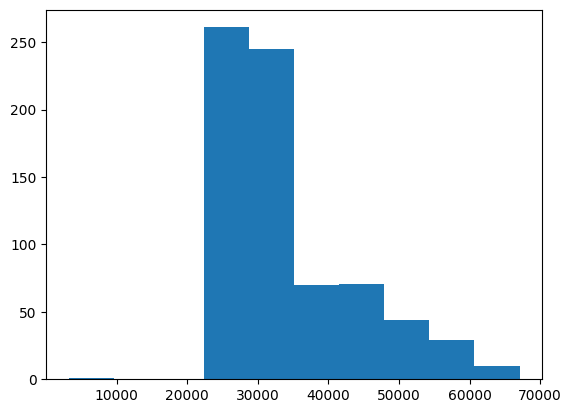

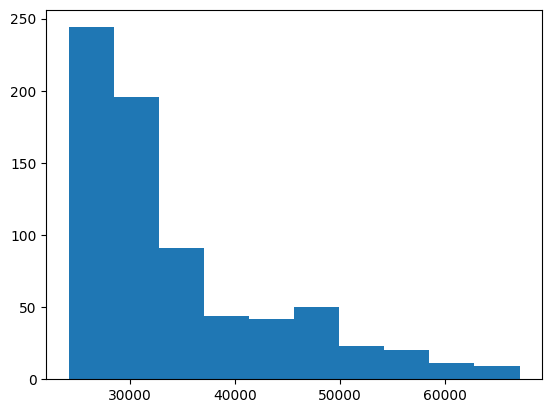

In [9]:
# OUTLIERS
plt.hist(df_mod.energie_soutiree_mwh)
plt.show()
df_mod = df_mod.loc[df_mod["energie_soutiree_mwh"] > 10000, :]
plt.hist(df_mod.energie_soutiree_mwh)
plt.show()

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
# ! pip install sklearn
from sklearn.model_selection import train_test_split

df_mod['date'] = pd.to_datetime(df_mod['date'])
df_mod['WeekDay'] = df_mod['date'].dt.weekday
data = df_mod.dropna(subset = ["temperature"])
X = data["temperature"]
y = data["energie_soutiree_mwh"]

# SPLIT DATA  70% - 15% - 15%
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state = 21)  # train et validation pour choisiir le modèle
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state = 21)   # test pour tester le modèle final. 

# TRAIN
best_score = float('inf')
best_degree = 1
for degree in range(1, 8):  # Tester les degrés de 1 à 8
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    scores = cross_val_score(model, X_train.values.reshape(-1, 1), y_train, scoring='neg_mean_squared_error', cv=10)
    score = -scores.mean()
    
    if score < best_score:
        best_score = score
        best_degree = degree
# Afficher le meilleur degré pour chaque jour
print("Best degree with cross-validation : ", best_degree)

model = make_pipeline(PolynomialFeatures(best_degree), LinearRegression())
model.fit(X_train.values.reshape(-1, 1), y_train)


Best degree with cross-validation :  6


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=6)),
                ('linearregression', LinearRegression())])

In [11]:
# TEST

y_pred = model.predict(X_val.values.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'Degree {best_degree}, RMSE: {rmse}')


Degree 6, RMSE: 3748.903311086037


In [12]:
# SAVE
import joblib
# joblib.dump(model, f'models/model_res.pkl')
# joblib.dump(model, f'models/model_res_pond.pkl')
# joblib.dump(model, f'models/model_res_pond2.pkl')

In [13]:
# LOAD MODEL
# model = joblib.load('models/model_res.pkl')
# model = joblib.load('models/model_res_pond.pkl')
# model = joblib.load('models/model_res_pond2.pkl')

In [14]:
# GRAPHES
# fig, axs = plt.subplots(4, 2, figsize=(15, 20))
# fig.tight_layout(pad=5.0)

# for day in range(7):
#     row = day // 2
#     col = day % 2
#     data = test_by_weekday[day]
#     X_day = data[['Température (°C)']]
#     y_day = data['energie_soutiree_mwh']
    
#     # Prédictions pour la courbe du modèle
#     X_fit = np.linspace(X_day['Température (°C)'].min(), X_day['Température (°C)'].max(), 100).reshape(-1, 1)
#     y_fit = models[day].predict(X_fit)
    
#     # Tracer les points de test et la courbe du modèle
#     axs[row, col].scatter(X_day, y_day, color='blue', label='Données test')
#     axs[row, col].plot(X_fit, y_fit, color='red', label=f'Modèle (degré {best_degrees[day]})')
#     axs[row, col].set_title(days_of_week[day])
#     axs[row, col].set_xlabel('Température (°C)')
#     axs[row, col].set_ylabel('Consommation brute électricité (MW)')
#     axs[row, col].legend()

# # Supprimer le dernier sous-graphe vide
# fig.delaxes(axs[3, 1])

# plt.show()

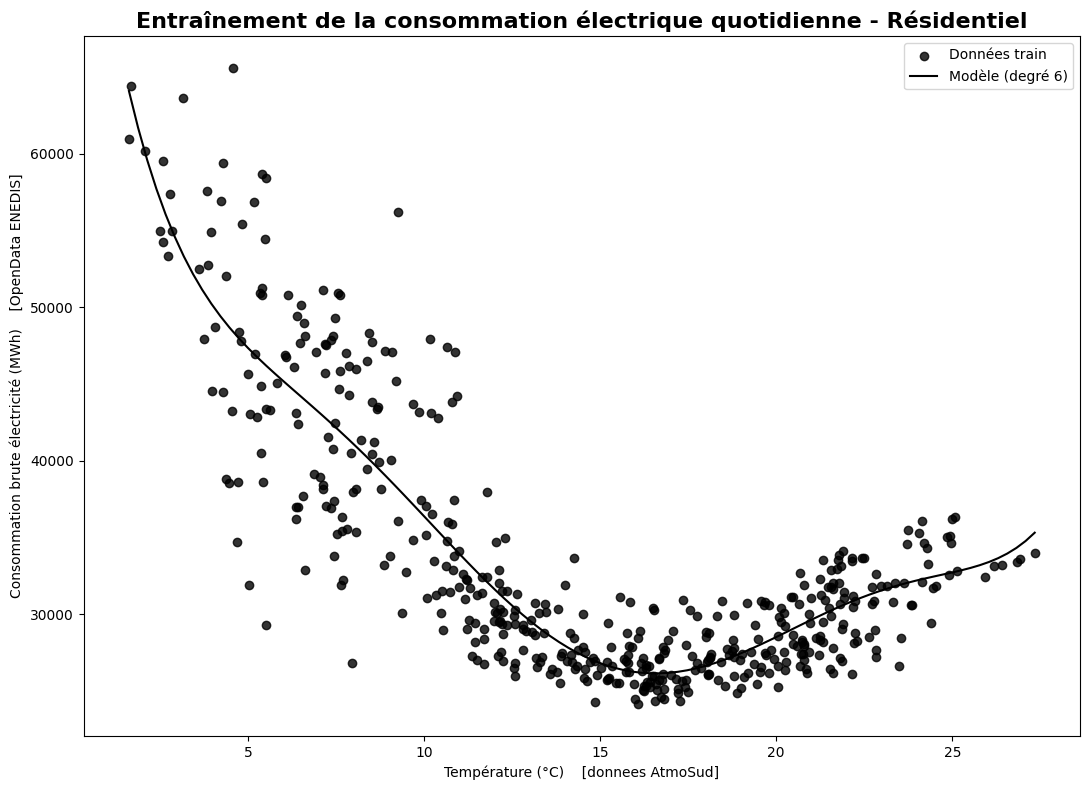

In [15]:
# Création d'un seul graphique TRAIN
plt.figure(figsize=(11, 8))

# Prédictions pour la courbe du modèle
X_fit = np.linspace(X_train.min(), X_train.max(), 100).reshape(-1, 1)
y_fit = model.predict(X_fit)

# Tracer les points de test et la courbe du modèle
plt.scatter(X_train, y_train, color = 'black', label=f'Données train', alpha=0.8)
plt.plot(X_fit, y_fit, color = 'black', label=f'Modèle (degré {best_degree})')

plt.title('Entraînement de la consommation électrique quotidienne - Résidentiel', weight = 'bold', fontsize = 16)
plt.xlabel('Température (°C)    [donnees AtmoSud]')
plt.ylabel('Consommation brute électricité (MWh)    [OpenData ENEDIS]')
plt.legend()
plt.tight_layout()
plt.show()

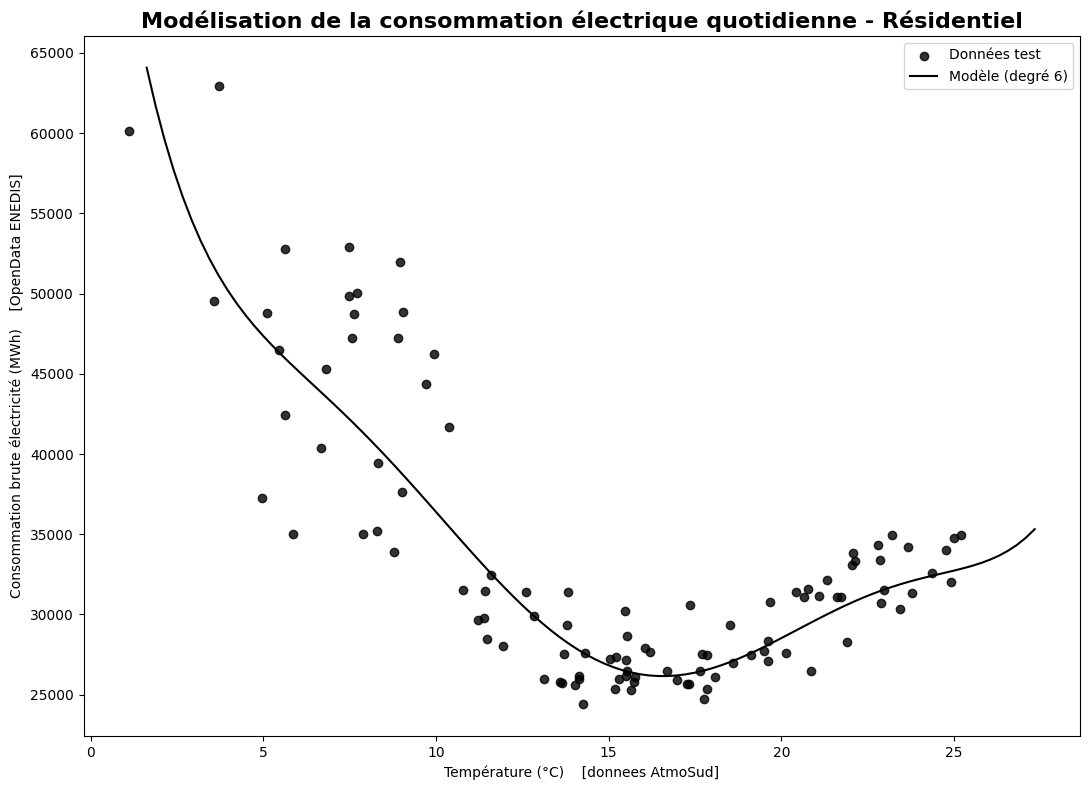

In [16]:
# Création d'un seul graphique
plt.figure(figsize=(11, 8))

# Prédictions pour la courbe du modèle
X_fit = np.linspace(X_train.min(), X_train.max(), 100).reshape(-1, 1)
y_fit = model.predict(X_fit)

# Tracer les points de test et la courbe du modèle
plt.scatter(X_test, y_test, color = 'black', label=f'Données test', alpha=0.8)
plt.plot(X_fit, y_fit, color = 'black', label=f'Modèle (degré {best_degree})')

plt.title('Modélisation de la consommation électrique quotidienne - Résidentiel', weight = 'bold', fontsize = 16)
plt.xlabel('Température (°C)    [donnees AtmoSud]')
plt.ylabel('Consommation brute électricité (MWh)    [OpenData ENEDIS]')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
def conso0_paca(tempe):
    """Returns estimated value for Electric Consumption according to a temperature value, based on a Polynomial Regression (degree 7).

    Args:
        tempe (float): Temperature in °C

    Returns:
        float: Estimated value of consumption
    """     
    x = np.array([[tempe]])
    return np.round(model.predict(x)[0], 2)

conso0_paca(tempe = 20)

28523.07

In [18]:
def polyn_paca(model):
    # Extraire les coefficients et l'intercept
    intercept = model.named_steps['linearregression'].intercept_
    coefficients = model.named_steps['linearregression'].coef_

    # Créer la formule de régression
    formula = f'{intercept:.2f} '
    for i, coef in enumerate(coefficients):
        if i != 0:
            formula += f'+ ({coef} * tempe**{i})'
    return formula


print(f"conso = ", polyn_paca(model))

conso =  87430.11 + (-20095.08277786156 * tempe**1)+ (4219.728678066393 * tempe**2)+ (-482.5300092060183 * tempe**3)+ (28.074054017762844 * tempe**4)+ (-0.7877522906343015 * tempe**5)+ (0.008504717233948255 * tempe**6)


In [19]:
tempe = 25
conso =  87430.11 + (-20095.08277786156 * tempe**1)+ (4219.728678066393 * tempe**2)+ (-482.5300092060183 * tempe**3)+ (28.074054017762844 * tempe**4)+ (-0.7877522906343015 * tempe**5)+ (0.008504717233948255 * tempe**6)
conso

32732.938908327604

In [20]:
conso0_paca(25)

32732.94

In [21]:
# D'AUTRES MODELES ?
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

rmses = []

# Régression par arbre de décision
tree_model = DecisionTreeRegressor(random_state=21)
tree_model.fit(X_train.values.reshape(-1, 1), y_train)
tree_y_pred = tree_model.predict(X_test.values.reshape(-1, 1))
tree_rmse = np.sqrt(mean_squared_error(y_test, tree_y_pred))

# Régression par forêts aléatoires
rf_model = RandomForestRegressor(random_state=21)
rf_model.fit(X_train.values.reshape(-1, 1), y_train)
rf_y_pred = rf_model.predict(X_test.values.reshape(-1, 1))
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_y_pred))

# Régression par machine à vecteurs de support (SVM)
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train.values.reshape(-1, 1), y_train)
svm_y_pred = svm_model.predict(X_test.values.reshape(-1, 1))
svm_rmse = np.sqrt(mean_squared_error(y_test, svm_y_pred))

rmses.append([tree_rmse, rf_rmse, svm_rmse])
    
results_df = pd.DataFrame(rmses, columns=['Tree', 'Random Forest', 'SVM'])
results_df

,Tree,Random Forest,SVM
0,4687.601721,4146.698904,8851.951821


### Modelisation Edge-Case

Pour les valeurs extrêmes de froid ou de chaud non vues lors de l'entraînement, la régression polynomiale peut faire un peu n'importe quoi. On va donc contrôler ceci en appliquant une régression linéaire, moins capricieuse, pour ces valeurs extrêmes.

Conso(tempe faible) = 66704.23588245558 + (-3902.887827704622 * tempefaible)
R2 : 0.33


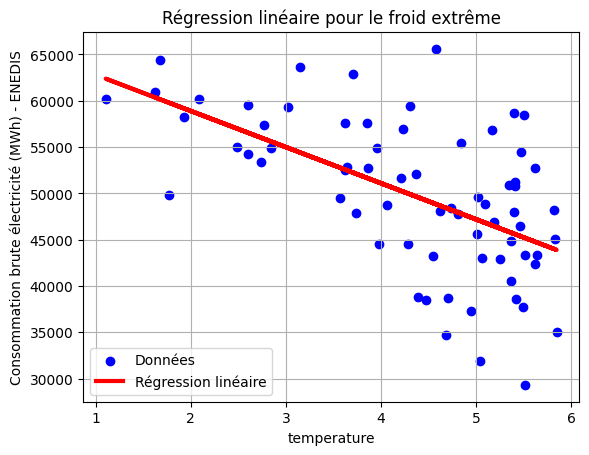

In [22]:
# Sous 1 degré : reg linéaire entraînée sous 6 degrés
from sklearn.linear_model import LinearRegression

seuil_train = 6

data = df_mod.dropna(subset = ["temperature"])
data = data.loc[data["temperature"] < seuil_train, :] # froid
X = pd.DataFrame(data["temperature"])
y = data["energie_soutiree_mwh"]

lr1 = LinearRegression()
lr1.fit(X, y)

print(f"Conso(tempe faible) = {lr1.intercept_} + ({lr1.coef_[0]} * tempefaible)")
print(f"R2 : {lr1.score(X, y):.2f}")

# Tracer les points de données
plt.scatter(X, y, color='blue', label='Données')
# Tracer la droite de régression
plt.plot(X, lr1.predict(X), color='red', linewidth=3, label='Régression linéaire')
plt.title(f'Régression linéaire pour le froid extrême')
plt.xlabel('temperature')
plt.ylabel('Consommation brute électricité (MWh) - ENEDIS')
plt.legend()
plt.grid(True)
plt.show()

Conso(tempe haute) = 13295.935215642927 + (799.4012802720838 * tempehaute)
R2 : 0.18


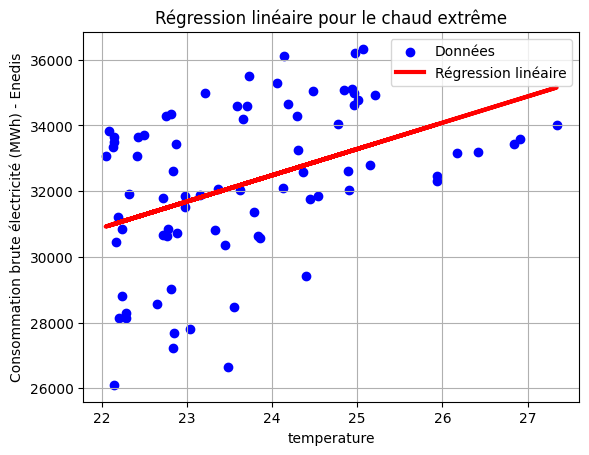

In [23]:
# Au-dessus de 28 degrés : reg linéaire entraînée au-dessus de 23 degrés
from sklearn.linear_model import LinearRegression

seuil_train = 22

data = df_mod.dropna(subset = ["temperature"])
data = data.loc[data["temperature"] > seuil_train, :] # chaud
X = pd.DataFrame(data["temperature"])
y = data["energie_soutiree_mwh"]

lr2 = LinearRegression()
lr2.fit(X, y)
 
 
print(f"Conso(tempe haute) = {lr2.intercept_} + ({lr2.coef_[0]} * tempehaute)")
print(f"R2 : {lr2.score(X, y):.2f}")

# Tracer les points de données
plt.scatter(X, y, color='blue', label='Données')
# Tracer la droite de régression
plt.plot(X, lr2.predict(X), color='red', linewidth=3, label='Régression linéaire')
plt.title(f'Régression linéaire pour le chaud extrême')
plt.xlabel('temperature')
plt.ylabel('Consommation brute électricité (MWh) - Enedis')
plt.legend()
plt.grid(True)
plt.show()

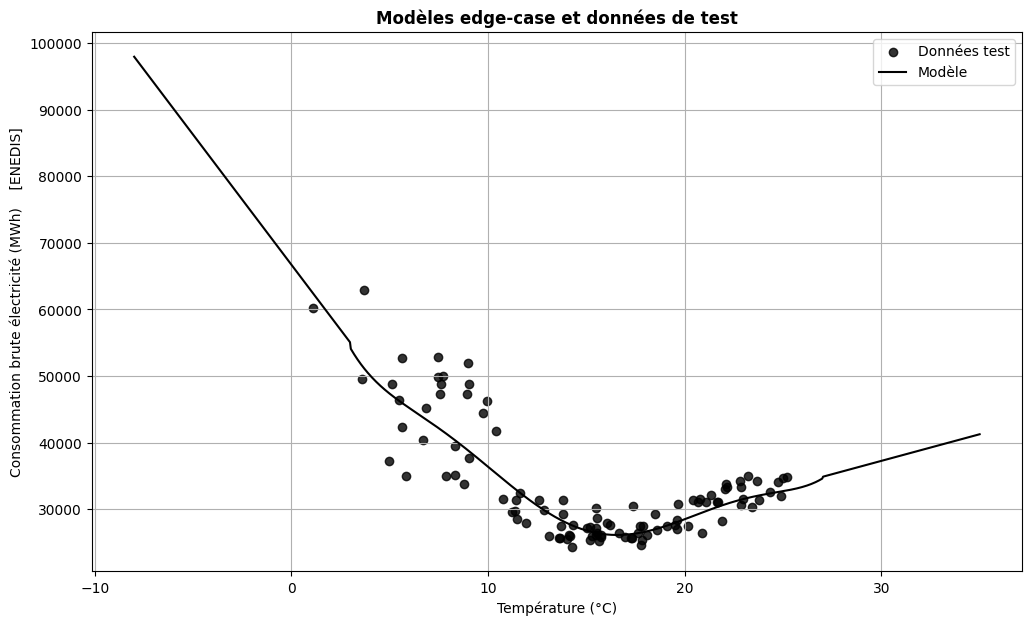

Formule Regression Edge-Case :
ConsoPaca = (tempe < 3) * (66704.24 + (-3902.89 * tempe)) + (tempe >= 3 and tempe < 27) * (87430.11 + (-20095.08277786156 * tempe**1)+ (4219.728678066393 * tempe**2)+ (-482.5300092060183 * tempe**3)+ (28.074054017762844 * tempe**4)+ (-0.7877522906343015 * tempe**5)+ (0.008504717233948255 * tempe**6)) + (tempe >= 27) * (13295.94 + (799.40 * tempe))



In [24]:
# Limites de température
seuil_froid = 3
seuil_chaud = 27

# Définir la fonction conso_paca pour chaque jour
def conso_paca(tempe,):
    if tempe < seuil_froid:
        conso = lr1.predict([[tempe]])[0]
    elif tempe < seuil_chaud:
        conso = model.predict([[tempe]])[0]
    else:  # tempe >= seuil_chaud
        conso = lr2.predict([[tempe]])[0]  
    return np.round(conso, 2)

# Préparation des jours de la semaine et des couleurs
days_of_week = {0: 'Lundi', 1: 'Mardi', 2: 'Mercredi', 3: 'Jeudi', 4: 'Vendredi', 5: 'Samedi', 6: 'Dimanche'}
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'black']

# Tracer les points de données de test et les courbes des modèles
plt.figure(figsize=(12, 7))
# Générer des valeurs pour la courbe
temps = np.linspace(-8, 35, 1000)
# Tracer les points de test pour chaque jour
plt.scatter(X_test, y_test, color = 'black', label=f'Données test', alpha=0.8)
# Tracer les courbes de modèles
conso = [conso_paca(t) for t in temps]
# conso = [model.predict([[t]])[0] for t in temps]  # Graphe extreme nimp
plt.plot(temps, conso, color = 'black', label=f'Modèle')

plt.title('Modèles edge-case et données de test', weight='bold')
plt.xlabel('Température (°C)')
plt.ylabel('Consommation brute électricité (MWh)    [ENEDIS]')
plt.legend()
plt.grid(True)
plt.show()

# Affichage de la formule de la régression edge-case pour chaque jour
def formule_paca(lr1, lr2):
    return f"(tempe < {seuil_froid}) * ({lr1.intercept_:.2f} + ({lr1.coef_[0]:.2f} * tempe)) + " \
           f"(tempe >= {seuil_froid} and tempe < {seuil_chaud}) * ({polyn_paca(model)}) + " \
           f"(tempe >= {seuil_chaud}) * ({lr2.intercept_:.2f} + ({lr2.coef_[0]:.2f} * tempe))"

print(f"Formule Regression Edge-Case :\nConsoPaca = {formule_paca(lr1, lr2)}\n")

In [25]:
tempe = 20
(tempe < 3) * (66704.24 + (-3902.89 * tempe)) + (tempe >= 3 and tempe < 27) * (87430.11 + (-20095.08277786156 * tempe**1)+ (4219.728678066393 * tempe**2)+ (-482.5300092060183 * tempe**3)+ (28.074054017762844 * tempe**4)+ (-0.7877522906343015 * tempe**5)+ (0.008504717233948255 * tempe**6)) + (tempe >= 27) * (13295.94 + (799.40 * tempe))


28523.067806158564

In [26]:
tempe = -10
(tempe < 3) * (66704.24 + (-3902.89 * tempe)) + (tempe >= 3 and tempe < 27) * (87430.11 + (-20095.08277786156 * tempe**1)+ (4219.728678066393 * tempe**2)+ (-482.5300092060183 * tempe**3)+ (28.074054017762844 * tempe**4)+ (-0.7877522906343015 * tempe**5)+ (0.008504717233948255 * tempe**6)) + (tempe >= 27) * (13295.94 + (799.40 * tempe))

105733.14000000001

In [27]:
conso_paca(-10)

105733.11

In [28]:
def formulesql_paca(lr1, model, lr2):
    # Extraire les coefficients et l'intercept
    intercept = model.named_steps['linearregression'].intercept_
    coefficients = model.named_steps['linearregression'].coef_

    # Créer la formule de régression
    polynome = f'{intercept:.2f} '
    for i, coef in enumerate(coefficients):
        if i != 0:
            polynome += f'+ ({coef} * POW(Temperature, {i}))'
    return f"\n     CASE WHEN Temperature < {seuil_froid} THEN ({lr1.intercept_} + ({lr1.coef_[0]} * Temperature)) * part_conso_comm\n         WHEN Temperature BETWEEN {seuil_froid} and {seuil_chaud} THEN ({polynome}) * part_conso_comm \n         ELSE ({lr2.intercept_} + ({lr2.coef_[0]} * Temperature)) * part_conso_comm \n     END"


print(formulesql_paca(lr1, model, lr2))


     CASE WHEN Temperature < 3 THEN (66704.23588245558 + (-3902.887827704622 * Temperature)) * part_conso_comm
         WHEN Temperature BETWEEN 3 and 27 THEN (87430.11 + (-20095.08277786156 * POW(Temperature, 1))+ (4219.728678066393 * POW(Temperature, 2))+ (-482.5300092060183 * POW(Temperature, 3))+ (28.074054017762844 * POW(Temperature, 4))+ (-0.7877522906343015 * POW(Temperature, 5))+ (0.008504717233948255 * POW(Temperature, 6))) * part_conso_comm 
         ELSE (13295.935215642927 + (799.4012802720838 * Temperature)) * part_conso_comm 
     END


### Test


In [29]:
y_pred = model.predict(X_test.values.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
part_rmse = np.round(rmse / np.sqrt(np.power(y_test.mean(), 2)) * 100, 4)
print("Root-Mean-Squared-Error : ", rmse, "soit", part_rmse, " %")
mae = mean_absolute_error(y_test, y_pred)
part_mae = np.round(mae / y_test.mean() * 100, 4)
print("Mean-Absolute-Error : ", mae, "soit", part_mae, " %")     # anciennement (donnees_synop_omm ; 4 stations) 8% et 5.7%  ;  donnes tempe non ponderees : 12% et 8%

Root-Mean-Squared-Error :  4102.548750748649 soit 12.3145  %
Mean-Absolute-Error :  2825.2737705659647 soit 8.4805  %


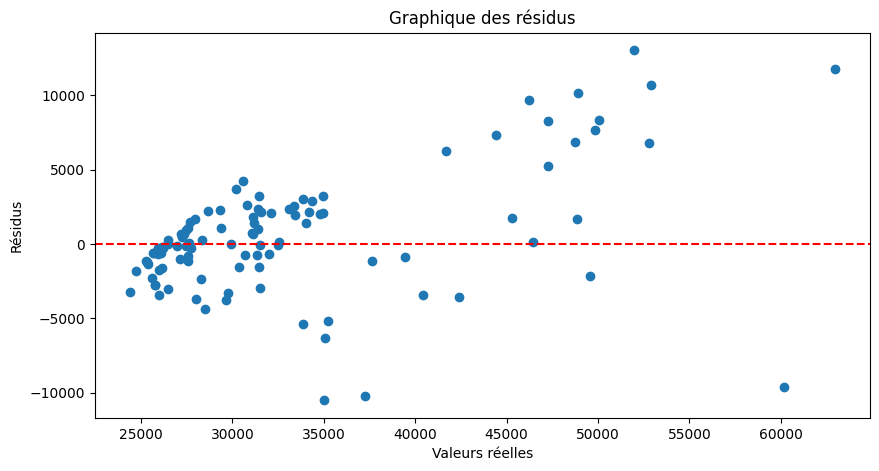

In [30]:
# Calcul des résidus
residuals = y_test - y_pred

# Visualisation des résidus
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')
plt.show()

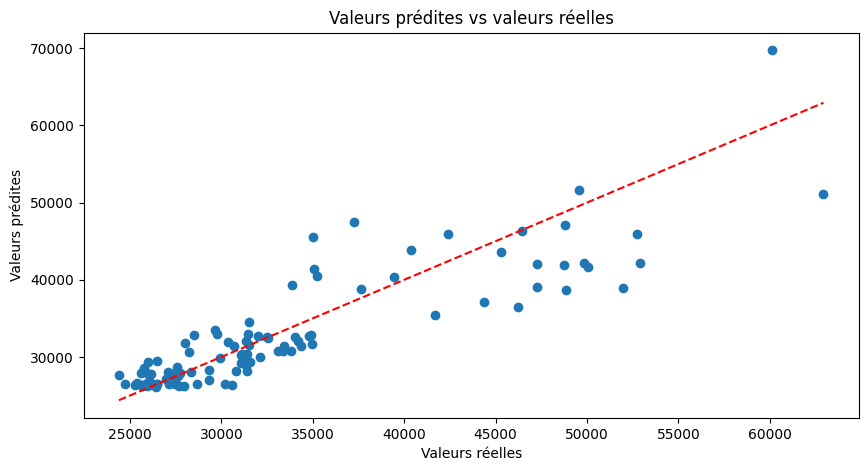

Coefficient de corrélation de Pearson: 0.879
Valeur-p: 0.000


In [31]:
from scipy.stats import spearmanr, pearsonr

plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs prédites vs valeurs réelles')
plt.show()

# Calcul du coefficient de corrélation de Spearman
spearman_corr, p_value = pearsonr(y_test, y_pred)

print(f"Coefficient de corrélation de Pearson: {spearman_corr:.3f}")
print(f"Valeur-p: {p_value:.3f}")

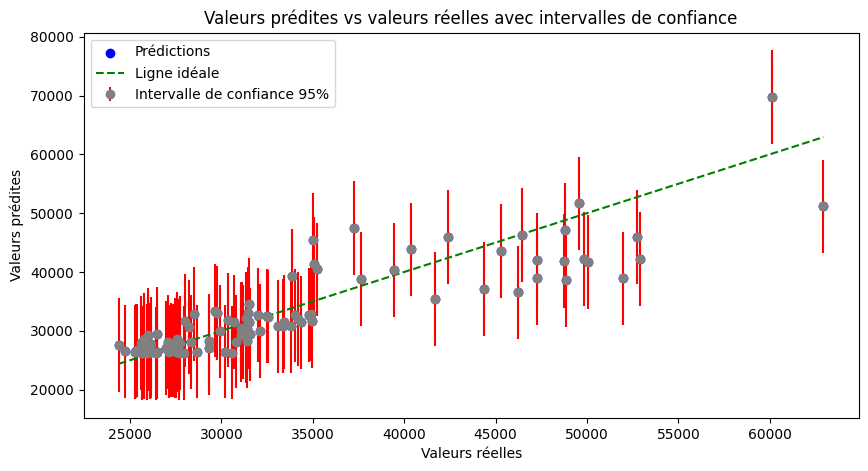

In [32]:
import scipy.stats as stats

# Calcul des résidus (erreurs)
residuals = y_test - y_pred

# Calcul des paramètres de l'erreur
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)

# Niveau de confiance (par exemple 95%)
confidence_level = 0.95
z_score = stats.norm.ppf((1 + confidence_level) / 2)

# Calcul de l'intervalle de confiance pour chaque prédiction
ci_lower = y_pred - z_score * std_residual
ci_upper = y_pred + z_score * std_residual

# Affichage des résultats
# for i, pred in enumerate(y_pred):
#     print(f"Prédiction: {pred:.2f}, Intervalle de confiance: [{ci_lower[i]:.2f}, {ci_upper[i]:.2f}]")

# Optionnel: Tracé des intervalles de confiance avec les prédictions
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, label='Prédictions', color='blue')
plt.errorbar(y_test, y_pred, yerr=z_score * std_residual, fmt='o', color='gray', ecolor='red', label='Intervalle de confiance 95%')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='green', linestyle='--', label='Ligne idéale')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs prédites vs valeurs réelles avec intervalles de confiance')
plt.legend()
plt.show()

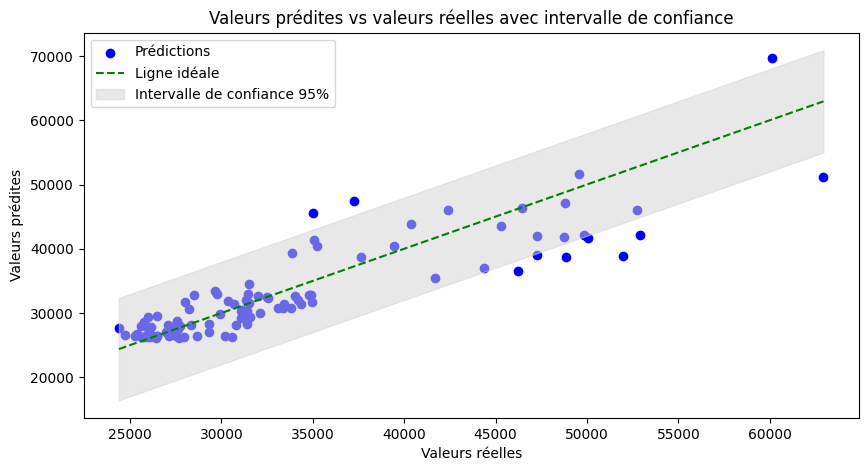

In [33]:
import scipy.stats as stats

# Calcul des résidus (erreurs)
residuals = y_test - y_pred

# Calcul des paramètres de l'erreur
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)

# Niveau de confiance (par exemple 95%)
confidence_level = 0.95
z_score = stats.norm.ppf((1 + confidence_level) / 2)

# Calcul de l'intervalle de confiance pour chaque prédiction
ci_lower = y_test - z_score * std_residual
ci_upper = y_test + z_score * std_residual

# TRI
# sorted_indices = np.argsort(pd.Series(y_test).reset_index(drop=True))
# y_test_sorted = y_test[sorted_indices]
# ci_lower_sorted = ci_lower[sorted_indices]
# ci_upper_sorted = ci_upper[sorted_indices]

# Affichage des résultats
# for i, pred in enumerate(y_pred):
#     print(f"Prédiction: {pred:.2f}, Intervalle de confiance: [{ci_lower[i]:.2f}, {ci_upper[i]:.2f}]")

# Optionnel: Tracé des intervalles de confiance avec les prédictions
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, label='Prédictions', color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='green', linestyle='--', label='Ligne idéale')
plt.fill_between(y_test.sort_values(), ci_lower.sort_values(), ci_upper.sort_values(), color='lightgray', alpha=0.5, label='Intervalle de confiance 95%')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs prédites vs valeurs réelles avec intervalle de confiance')
plt.legend()
plt.show()

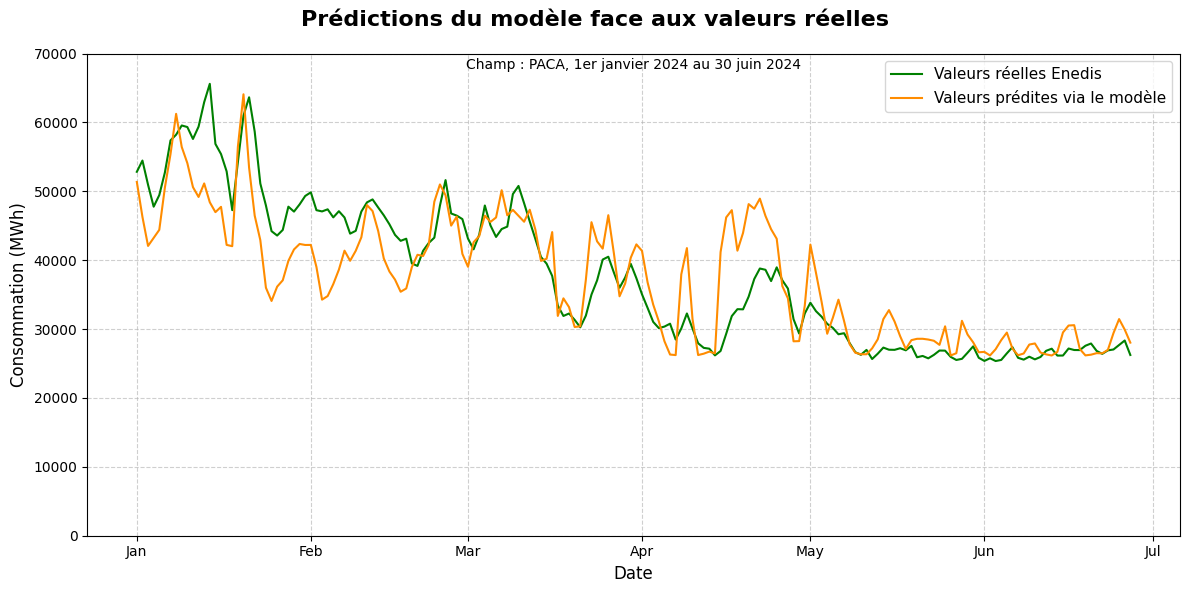

In [34]:
# TEST MODELE SUR 2024
df_test = df_mod.copy()
df_test = df_test[df_test["date"] >= pd.to_datetime("2024-01-01")]
values_2024 = df_test["energie_soutiree_mwh"].reset_index(drop=True)
y_pred_2024 = pd.Series(model.predict(df_test["temperature"].values.reshape(-1, 1)))

plt.figure(figsize=(12, 6))
sns.lineplot(values_2024, label = "Valeurs réelles Enedis", color = "green")
sns.lineplot(y_pred_2024, label = "Valeurs prédites via le modèle", color = "darkorange")

# parametres
plt.ylim((0, 70000))
plt.suptitle("Prédictions du modèle face aux valeurs réelles", fontsize=16, weight = 'bold')
plt.title("Champ : PACA, 1er janvier 2024 au 30 juin 2024", fontsize = 10, ha = 'center', y=0.95)
plt.xlabel('Date', fontsize=12)
# Formater l'axe des abscisses pour afficher seulement un mois à la fois
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Un mois à la fois
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Afficher uniquement le mois (Jan, Feb...)
plt.ylabel('Consommation (MWh)', fontsize=12)
plt.legend(fontsize='11')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

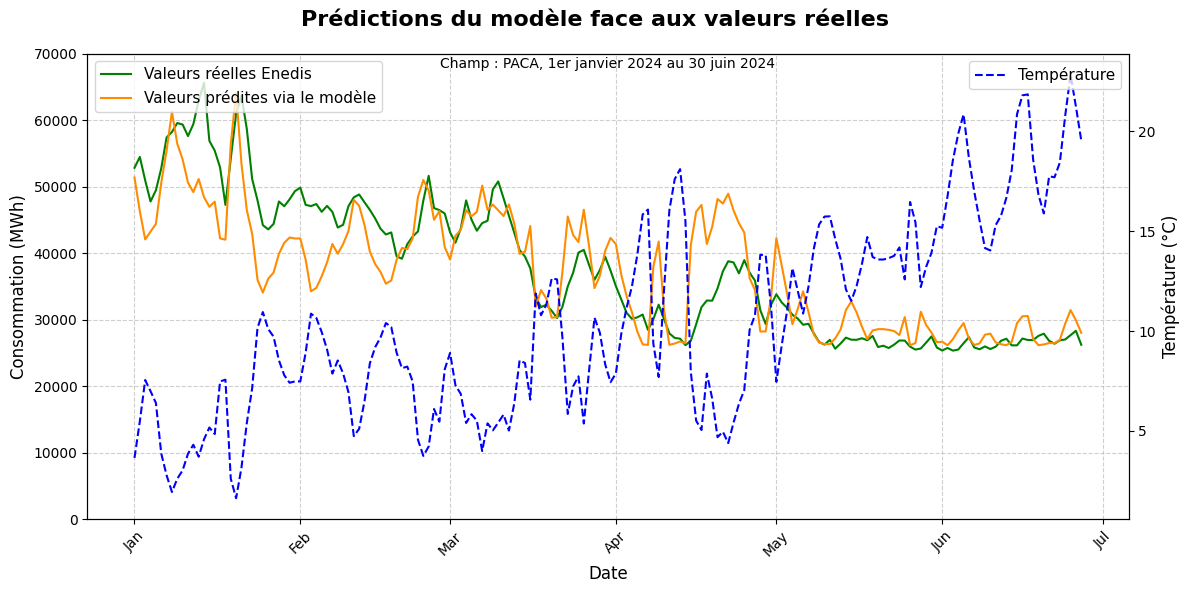

In [35]:
# TEST MODELE SUR 2024 avec tempe
df_test = df_mod.copy()
df_test = df_test[df_test["date"] >= pd.to_datetime("2024-01-01")]
values_2024 = df_test["energie_soutiree_mwh"].reset_index(drop=True)
y_pred_2024 = pd.Series(model.predict(df_test["temperature"].values.reshape(-1, 1)))
temperatures_2024 = df_test["temperature"].reset_index(drop=True)

fig, ax1 = plt.subplots(figsize=(12, 6))
sns.lineplot(values_2024, label = "Valeurs réelles Enedis", color = "green", ax = ax1)
sns.lineplot(y_pred_2024, label = "Valeurs prédites via le modèle", color = "darkorange", ax = ax1)

# temperature sur un ax2
ax2 = ax1.twinx()
sns.lineplot(temperatures_2024, label = "Température",linestyle = '--', color = "blue", ax = ax2)

# Paramètres pour l'axe principal (consommation)
ax1.set_ylim((0, 70000))
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Consommation (MWh)', fontsize=12)
ax1.legend(loc='upper left', fontsize='11')
ax1.grid(True, linestyle='--', alpha=0.6)
# Formater l'axe des abscisses pour afficher seulement un mois à la fois
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax1.tick_params(axis='x', rotation=45)
# Paramètres pour l'axe secondaire (température)
ax2.set_ylabel('Température (°C)', fontsize=12)
ax2.legend(loc='upper right', fontsize='11')

plt.suptitle("Prédictions du modèle face aux valeurs réelles", fontsize=16, weight='bold')
plt.title("Champ : PACA, 1er janvier 2024 au 30 juin 2024", fontsize=10, ha='center', y=0.95)
fig.tight_layout()
plt.show()

In [36]:
print(formulesql_paca(lr1, model, lr2))


     CASE WHEN Temperature < 3 THEN (66704.23588245558 + (-3902.887827704622 * Temperature)) * part_conso_comm
         WHEN Temperature BETWEEN 3 and 27 THEN (87430.11 + (-20095.08277786156 * POW(Temperature, 1))+ (4219.728678066393 * POW(Temperature, 2))+ (-482.5300092060183 * POW(Temperature, 3))+ (28.074054017762844 * POW(Temperature, 4))+ (-0.7877522906343015 * POW(Temperature, 5))+ (0.008504717233948255 * POW(Temperature, 6))) * part_conso_comm 
         ELSE (13295.935215642927 + (799.4012802720838 * Temperature)) * part_conso_comm 
     END


## fin